In [1]:
import requests
import json
import pickle
from bs4 import BeautifulSoup as bs
import re

In [2]:
def get_seasons():
    seasons = range(1,11)
    season_list = []
    season_url = 'https://adventuretime.fandom.com/api/v1/Articles/List?expand=1&category=season+{}&namespaces=0&limit=50'
    for season in seasons:
        r = requests.get(season_url.format(season)).text
        json_r = json.loads(r)
        season_list.append(json_r)
    return season_list

# creates a dictionary with episode title as key and its season as value
episode_season = {}
for i, season in enumerate(get_seasons()):
    for episode in season['items']:
        title = episode['url'][6:]
        if ('Adventure_Time_Short:' in title or
            'Frog_Seasons:' in title or
            'Islands' == title or
            'Stakes' == title or
            'Elements' == title or
            'MonthBomb' == title): # a few titles that snuck in which are not episodes
            continue
        episode_season[title] = i+1

# creates a dictionary with season number as key and a list of episodes as value
season_episodes = {episode_season[e]:[]  for e in episode_season}
for ep in episode_season:
    season_episodes[episode_season[ep]].append(ep)

# returns a list of lines with charater names
def get_transcript(title):
    season_num = episode_season[title]
    transcript = pickle.load(open(f'seasons/season{season_num}/transcripts/{title}.txt', 'rb'))
    return transcript

# returns a list of lines without character names
def get_transcript_text(title):
    transcript = get_transcript(title)
    text = [re.sub(r'^.*?:\s*', '', line) for line in transcript]
    return text

# returns a dictionary with each character as key and their respective lines
# as values stored as a list
def get_transcript_characters(title):
    transcript = get_transcript(title)
    characters = [re.search(r'^.*?:', line).group()[:-1] for line in transcript]
    character_lines = {}
    for character in characters:
        character_lines[character] = []
    for line in transcript:
        character = re.search(r'^.*?:', line).group()[:-1]
        text = re.sub(r'^.*:\s', '', line)
        character_lines[character].append(text)
    return character_lines

def get_article(title):
    season_num = episode_season[title]
    article = pickle.load(open(f'seasons/season{season_num}/articles/{title}.json', 'rb'))
    return article

def get_major_characters(title):
    major_characters_raw = next(x for x in get_article(title)['sections'] 
                                    if (x['title'].lower().replace(u'\xa0', u' ') == 'major characters'
                                    or x['title'].lower() == 'main characters')) # workaround until wiki updates
    major_characters = major_characters_raw['content'][0]['elements']
    major_characters = [c['text'] for c in major_characters]
    major_characters = [c.replace(u'\xa0', u' ') for c in major_characters]
    major_characters = [re.sub(r'\s*\(.*?\)', '', c) for c in major_characters]
    major_characters = [re.sub(r'\s$', '', c) for c in major_characters]
    return major_characters

def get_minor_characters(title):
    minor_characters_raw = next(x for x in get_article(title)['sections'] 
                                    if x['title'].lower() == 'minor characters')
    minor_characters = minor_characters_raw['content'][0]['elements']
    minor_characters = [c['text'] for c in minor_characters]
    minor_characters = [c.replace(u'\xa0', u' ') for c in minor_characters]
    minor_characters = [re.sub(r'\s*\(.*?\)', '', c) for c in minor_characters]
    minor_characters = [re.sub(r'\s$', '', c) for c in minor_characters if c != 'Snail']
    return minor_characters

def get_all_characters(title):
    return get_major_characters(title) + get_minor_characters(title)

# Network analysis

In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
fig_size = (16,8)
%matplotlib inline
from itertools import combinations
from fa2 import ForceAtlas2
import community
import matplotlib.style as style
style.use('ggplot')

### Creating the network

In [4]:
# makes a directed graph and an undirected graph from a list
# of season numbers i.e. get_graphs_from([1,2])
def get_graphs_from(seasons):
    DG = nx.DiGraph()
    for season in seasons:
        for episode_title in season_episodes[season]:
            if episode_title == 'Come_Along_With_Me': # excludes come along with me since it is an anomaly
                continue
            DG.add_edges_from(combinations(get_all_characters(episode_title),2))
    G = DG.to_undirected()
    return DG, G

DG, G = get_graphs_from(range(1,11))
degree = list(dict(DG.degree()).values())
print(f"Number of nodes in network: {len(DG.nodes)}")
print(f"Number of edges in network: {len(DG.edges)}")

Number of nodes in network: 953
Number of edges in network: 12984


We start off by looking at network statistics for the characters across the entire series to get a sense of what to look for.

**Exploration of character importance (degree and centrality measurements)**

In [5]:
# creates a dictionary with season number as key and a tuple of directed and
# undirected graph as value for each season
network_season = {i:get_graphs_from([i]) for i in range(1,11)}

def sort_graph_property(graph):
    return sorted(dict(graph).items(), key = lambda x: x[1], reverse = True)

# sorted out degree per season and for entire series
out_degree_season = [sort_graph_property(network[0].out_degree)
                      for network in list(network_season.values())]
out_degree_all = sort_graph_property(DG.out_degree)

# sorted in degree per season and for entire series
in_degree_season = [sort_graph_property(network[0].in_degree)
                      for network in list(network_season.values())]
in_degree_all = sort_graph_property(DG.in_degree)

# sorted degree per season and for entire series
degree_season = [sort_graph_property(network[0].degree)
                      for network in list(network_season.values())]
degree_all = sort_graph_property(DG.degree)


# sorted betweenness centrality per season and for entire series
betweenness_season = [sort_graph_property(nx.algorithms.centrality
                                          .betweenness_centrality(network[0]))
                      for network in list(network_season.values())]
betweenness_all = sort_graph_property(nx.algorithms.centrality
                                      .betweenness_centrality(DG))

# sorted eigenvector centrality per season and for entire series
eigenvector_season = [sort_graph_property(nx.algorithms.centrality
                                        .eigenvector_centrality(network[0]))
                      for network in list(network_season.values())]
eigenvector_all = sort_graph_property(nx.algorithms.centrality
                                      .eigenvector_centrality(DG))

# sorted degree centrality per season and for entire series
degree_centr_season = [sort_graph_property(nx.algorithms.centrality
                                        .degree_centrality(network[0]))
                      for network in list(network_season.values())]
degree_centr_all = sort_graph_property(nx.algorithms.centrality.degree_centrality(DG))

In [6]:
def format_table_data(data):
    return ['{}: {}'.format(r[0], round(r[1],3)) for r in data]

pd.DataFrame({'Out-degree': format_table_data(out_degree_all[:10]),
              'In-degree': format_table_data(in_degree_all[:10]),
              'Total degree': format_table_data(degree_all[:10])})

,Out-degree,In-degree,Total degree
0,Finn: 832,BMO: 186,Jake: 980
1,Jake: 822,Candy People: 172,Finn: 964
2,BMO: 362,Jake: 158,BMO: 548
3,Princess Bubblegum: 337,Finn: 132,Princess Bubblegum: 457
4,Ice King: 319,Lady Rainicorn: 130,Ice King: 447
5,Marceline: 236,Ice King: 128,Marceline: 335
6,Lumpy Space Princess: 214,Princess Bubblegum: 120,Candy People: 301
7,Lady Rainicorn: 157,Gunter: 106,Lumpy Space Princess: 300
8,Gunter: 149,Tree Trunks: 103,Lady Rainicorn: 287
9,Peppermint Butler: 142,Peppermint Butler: 101,Gunter: 255


To no surprise we see that the central characters of the show have the largest out-degree, meaning they influence the most characters throughout the show.

To gain an understanding of the characters' influence, we looked at their degrees along with a few centrality measures. These being Betweenness, Eigenvector and degree centrality.

 * Betweenness centrality is a measure of how often a node is part of the shortest path between two other nodes. i.e. how many times a given node is used as a 'bridge' between two other nodes.

* Eigenvector centrality is used to get see if important nodes are often linked with other important nodes, thus making them more important.


* Degree centrality is the simplest form of centrality measure. This is the propability that a node is passed through when traversing the network.


In [7]:
pd.DataFrame({'Betweenness': format_table_data(betweenness_all[:10]),
              'Eigenvector': format_table_data(eigenvector_all[:10]),
              'Degree centrality': format_table_data(degree_centr_all[:10])})

,Betweenness,Eigenvector,Degree centrality
0,Jake: 0.196,Candy People: 0.197,Jake: 1.029
1,Finn: 0.148,BMO: 0.148,Finn: 1.013
2,BMO: 0.094,Peppermint Butler: 0.141,BMO: 0.576
3,Ice King: 0.069,Lady Rainicorn: 0.135,Princess Bubblegum: 0.48
4,Princess Bubblegum: 0.062,Ice King: 0.134,Ice King: 0.47
5,Candy People: 0.048,Tree Trunks: 0.131,Marceline: 0.352
6,Lady Rainicorn: 0.046,Jake: 0.128,Candy People: 0.316
7,Lumpy Space Princess: 0.04,Princess Bubblegum: 0.124,Lumpy Space Princess: 0.315
8,Tree Trunks: 0.036,Mr. Pig: 0.124,Lady Rainicorn: 0.301
9,Gunter: 0.033,Wyatt: 0.121,Gunter: 0.268


Both betweenness and degree centrality doesn't really tell us anything too interesting since it's the same bunch of central characters to the show which have the highest of those measures, but they were worth exploring. Eigenvector centrality, however, seems to favor characters which are often *associated* with important characters. The Candy People and Peppermint Butler is very often with Princess Bubblegum since she governs the Candy Kingdom where the Candy People recide and Peppermint Butler is following her every step. BMO is very often with Finn and Jake since they all live together in the tree house. Tree Trunks and Mr. Pig are married and somewhat often run into problems which Finn and Jake solves (Wyatt, who's Tree Trunks ex-husband, is also shown to have a high Eigenvector centrality).


In [54]:
pd.DataFrame({'season {}'.format(s+1): format_table_data(l[:5]) for s, l in enumerate(eigenvector_season)})

,season 1,season 2,season 3,season 4,season 5,season 6,season 7,season 8,season 9,season 10
0,Tree Trunks: 0.302,Mr. Goose: 0.412,Two-Headed Duck: 0.388,Scientific Parasite: 0.328,Candy People: 0.217,Candy People: 0.272,Worm: 0.246,BMO: 0.263,Lumpy Space People: 0.355,The Morrow: 0.358
1,King Worm: 0.291,Mrs. Yoder: 0.39,Mr. Pig: 0.347,Gumball Guardian: 0.304,Gunter: 0.212,King of Ooo: 0.247,Marceline's mom: 0.238,Candy People: 0.24,Wyatt: 0.33,Squirrel: 0.322
2,Lady Rainicorn: 0.271,Cat: 0.302,Tree Trunks: 0.31,Jellyfish: 0.292,BMO: 0.201,Penguins: 0.214,Spider Ghost: 0.221,The Lich: 0.229,Me-Mow: 0.307,Scorcher: 0.29
3,Centipede: 0.229,Chipmunk: 0.261,Phil: 0.278,Cow: 0.226,Gumball Guardian: 0.176,Laser Wizard: 0.21,Toronto: 0.212,Slime Princess: 0.206,Cosmic Owl: 0.286,Sir Slicer: 0.262
4,Wildberry Princess: 0.207,Owls: 0.225,Punch Bowl: 0.249,Banana Guards: 0.207,Finn: 0.16,Bufo: 0.192,Coal Man: 0.198,Gunter: 0.189,Prismo: 0.266,Ash: 0.236


This seems to be a pattern throughout the entire show. 'The Lich' is the main antagonist to the plot of the story for a while and is seen to get a high eigenvector centrality in season 8 meaning that the character must be interacting with the important characters of the show. In season 9 we see 'Cosmic Owl' and 'Prismo' which are characters very important to the plot of the show.

With the hypothesis in mind that the show relies less on the main characters throughout the show and tries to build to universe with more robust characters and backstory we plot the average degree for the important characters per episode for each season to get a feeling for which characters rise and fall in importance.

In [9]:
top_characters = list(dict(degree_all[:10]).keys()) 
char_degree = {c : [] for c in top_characters}

for char in char_degree.keys():
    for i, net in enumerate(network_season.values()):
        if char in dict(net[0].degree).keys():
            char_degree[char].append(net[0].degree[char] / len(season_episodes[i+1]))
        else:
            char_degree[char].append(None)

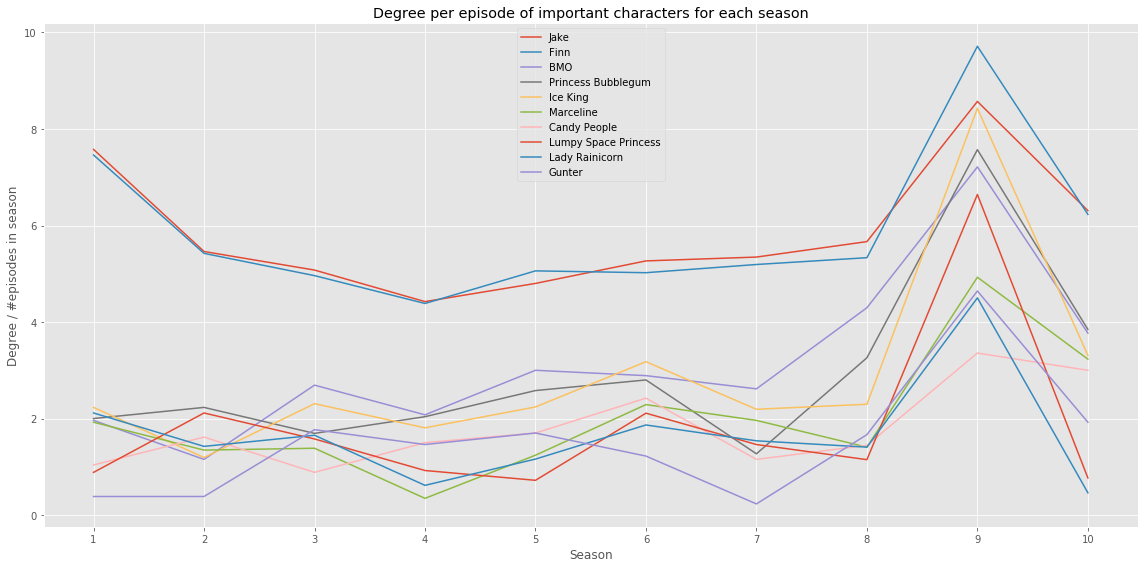

In [10]:
plt.figure(figsize=fig_size)
for char in char_degree:
    plt.plot(char_degree[char], label = char)
plt.xticks(range(10), range(1,11))
plt.legend()
plt.title("Degree per episode of important characters for each season")
plt.ylabel("Degree / #episodes in season")
plt.xlabel("Season")
plt.tight_layout()
plt.savefig('../normalized_degree.png')
plt.show()

In [11]:
print(f"Difference in degree for Finn from season 1-4: {round(char_degree['Finn'][5] - char_degree['Finn'][0], 3)}")
print(f"Difference in degree for Jake from season 1-4: {round(char_degree['Jake'][5] - char_degree['Jake'][0], 3)}")

Difference in degree for Finn from season 1-4: -2.439
Difference in degree for Jake from season 1-4: -2.31


We notice that Finn and Jake, the main characters of the show, has a decrease in average degree per episode of 2.4 and 2.3 respectively. This is presumably because the show introduces new characters and rely more on those as time goes on. This seems to be the only remarkable change within the main characters.

Since season 9 is heavy on serialisation rather than one-off episodes with a reliance on 'mini-series' it causes the out-degree of these main charaters to spike. This is because the main characters are consistently the same throughout the serialised episodes while minor characters are only seen very little.

We can investigate the average growth in degree from season to season sorted by largest growth to see which characters becomes more prominent.

In [12]:
def avg_degree_diff(seasons):
    degree_difference = {c: {} for c in G.nodes}
    for s in seasons:
        net1 = network_season[s][0]
        net2 = network_season[s+1][0]
        for char in net1:
            if char in net1.nodes and char in net2.nodes:
                degree_difference[char][s] = net2.degree[char] - net1.degree[char]
    degree_difference = {c: dd for c,dd  in degree_difference.items() if dd != {}}
    
    # sorted mean degree difference for each character in a season
    return sorted({c: round(np.mean(list(dd.values())) / (10-len(list(dd.values()))),2) 
                    for c, dd in degree_difference.items()}.items(), key = lambda x: x[1], reverse = True)

In [13]:
avg_degree_diff_season = [avg_degree_diff([i]) for i in range(1,10)]
pd.DataFrame({'season {}->{}'.format(s+1, s+2): format_table_data(l)[:5] for s, l in enumerate(avg_degree_diff_season)})

,season 1->2,season 2->3,season 3->4,season 4->5,season 5->6,season 6->7,season 7->8,season 8->9,season 9->10
0,Lumpy Space Princess: 3.56,BMO: 4.44,Penguins: 2.11,Finn: 15.44,Abracadaniel: 7.11,Crunchy: 3.11,Princess Bubblegum: 6.11,Lumpy Space Princess: 6.89,Gumbald: 3.33
1,Frog: 3.44,Gunter: 4.0,Candy People: 1.78,Jake: 13.89,King of Ooo: 6.67,Toronto: 1.44,BMO: 5.33,Flame People: 6.56,Starchy: 1.56
2,Candy People: 1.67,Ice King: 3.22,Cow: 1.11,BMO: 10.67,Lumpy Space Princess: 6.56,Banana Guards: 1.22,Gunter: 4.33,Ice King: 6.22,Banana Guards: 0.11
3,Forest Wizard: 1.33,Cinnamon Bun: 2.33,Princess Bubblegum: 1.0,Princess Bubblegum: 8.44,Martin: 6.56,Hot Dog Princess: 1.11,Turtle Princess: 2.33,Peppermint Butler: 4.56,Candyfish: -0.33
4,Tree People: 1.11,Tree Trunks: 2.0,Turtle Princess: 0.44,Ice King: 7.22,Penguins: 5.44,Starchy: 1.11,Cinnamon Bun: 1.89,Patience St. Pim: 4.56,Margaret: -0.56


**Degree distribution**

We also wish to investigate which kind of network we are dealing with (random, scale-free, etc.). This is done with a degree distribution.

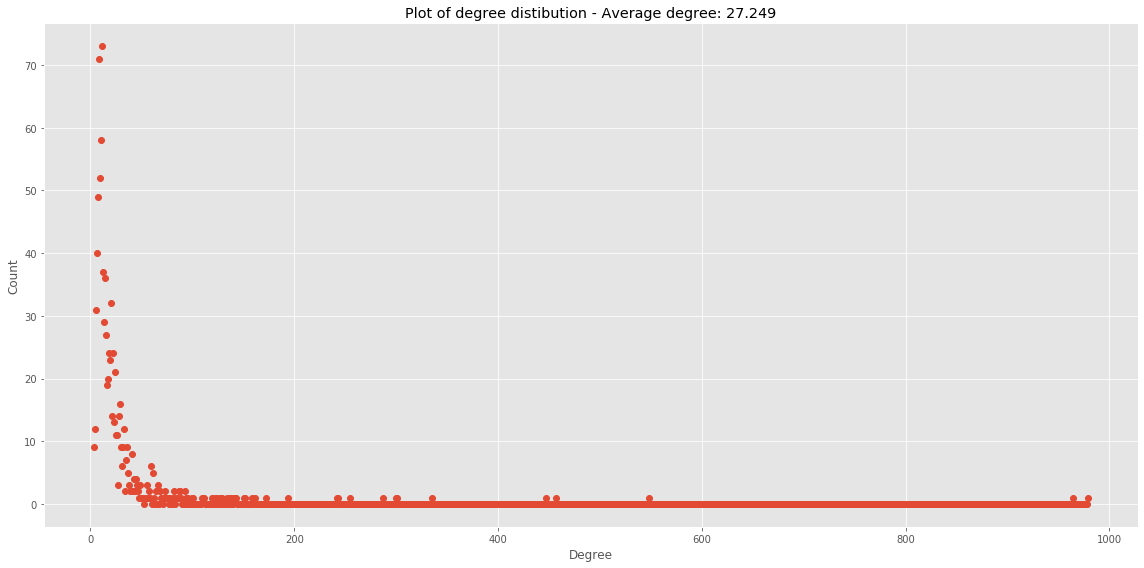

In [14]:
plt.figure(figsize=fig_size)
v = np.arange(min(degree), max(degree)+1)
h_1, b_1 = np.histogram(degree, bins = v)
plt.plot(b_1[:-1], h_1, 'o')
plt.title(f"Plot of degree distibution - Average degree: {round(np.mean(degree),3)}")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

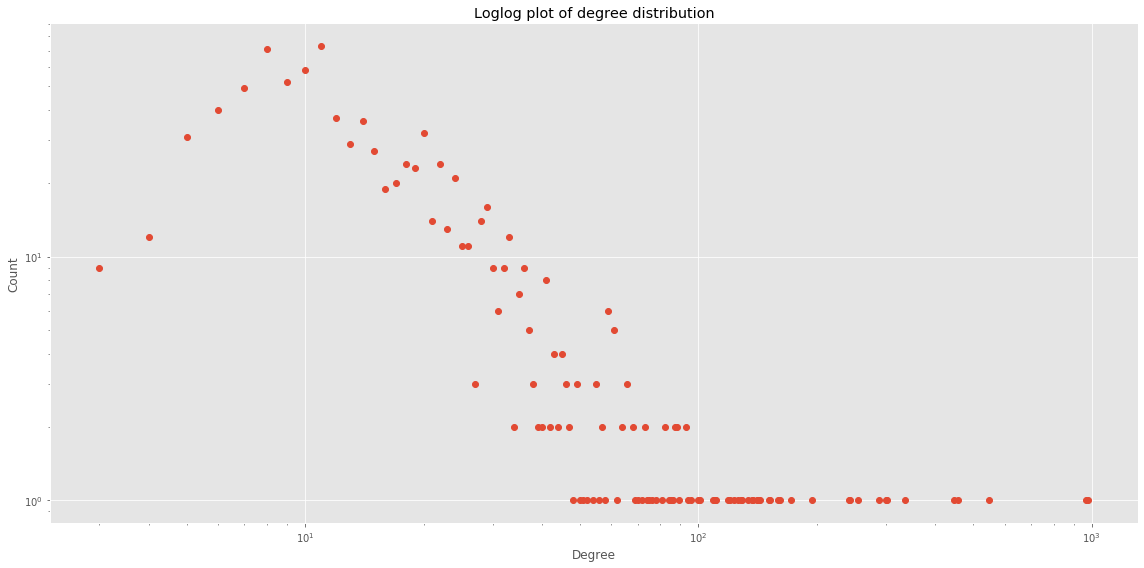

In [15]:
plt.figure(figsize=fig_size)
h_2, b_2 = np.histogram(degree, bins = v)
plt.loglog(b_2[:-1], h_2, 'o')
plt.title('Loglog plot of degree distribution')
plt.ylabel('Count')
plt.xlabel('Degree')
plt.tight_layout()
plt.savefig('../loglog.png')
plt.show()

From the loglog plot we clearly see that the degree distribution follows a poissonian distribution indicating a random network.

### Visualizing the network

In [16]:
# Force atlas 2 used to get positions and saved to local file
# to cut down on runtime
positions = pickle.load(open('position.p', 'rb'))

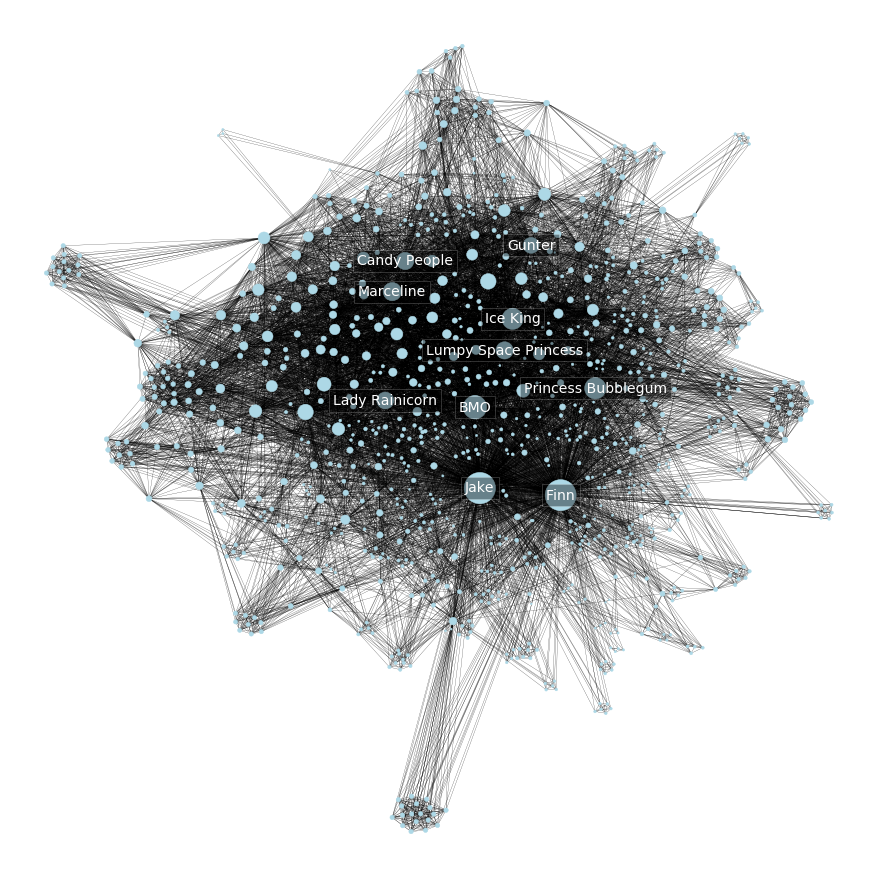

In [17]:
plt.figure(figsize=(12,12))
labels = {c:c for c in DG.nodes if c in dict(degree_all[:10]).keys()}
node_size = degree
nx.draw(G, node_size = node_size, pos = positions,
        width=.2, node_color = 'lightblue', with_labels = False)
nx.draw_networkx_labels(DG, positions, labels, font_size = 14, font_color = 'w',
                        bbox=dict(facecolor='black', alpha=0.4) )
plt.savefig("../network_plain.png")
plt.show()

There are noticable clusters throughout the network. These are found to represent episodes which has characters that are only used in that particular episode which causes them to only connect to each other. An example of this is an episode in which Finn and Jake travels to a city where everyone is a thief. This is the cluster at the bottom of the network. These thief characters are never used again outside of that episode.

This is easily verifiable by looking at the clustering coefficient of all the characters in the particular episode. This tells us how likely a node is to cluster together in a network and from the results we can see that every character in the episode apart from Finn, Jake and Phil have a clustering coefficient of 1 indicating that they are absolutely certain to form a cluster in the network.

In [18]:
pd.DataFrame(nx.algorithms.cluster.clustering(G, get_all_characters('City_of_Thieves_(episode)')).items(),
            columns = ["Character", "Clustering coefficient"])

,Character,Clustering coefficient
0,Finn,0.026953
1,Jake,0.026892
2,Penny,1.000000
3,Baskets & Boots Owner,1.000000
4,Big Guy,1.000000
5,Cherubs,1.000000
6,Crossbow Guy,1.000000
7,Cyclops,1.000000
8,Giant Turtle,1.000000
9,Goblin Thieves,1.000000


### Community detection

We can gain an understanding of which characters are more likely to connect to each other by looking into community detection and using the Lovain community detection algorithm for this purpose. Specifically we're interested in the modularity which describes to what degree the network is partitioned into relatively independent parts. If the modularity is larger than zero there is said to be a potential for communities.

There aren't really any predefined communities present in Adventure Time (apart from an exception - more on that later) so we don't have much in terms of comparing if the found results, but there seems to be indication that random networks can indeed contain high modularity partitions[1,s9.4]

We'll look at which communities are formed by the Louvain Community algorithm and attempt to infer meaning from those communities.

In [19]:
partition = community.best_partition(G)
modularity = community.modularity(partition, G)
print(f"Value of modularity found by Louvain Community Detection {modularity}")

communities = {}
for p, c in partition.items():
    communities[c] = communities.get(c, [])
    communities[c].append(p)

Value of modularity found by Louvain Community Detection 0.36326328186118834


This gives us an indication that the network contains potential communities. 

We'll plot these communities with random colors for each community to tell them apart.

In [20]:
# generates random colors to use for the communities
colors = ['#%02x%02x%02x' % tuple(np.random.randint(256, size = 3)) 
            for _ in range(25)]

def get_community_cmap(partition):
    color_map = []
    for com in partition.values():
        color_map.append(colors[com])
    return color_map

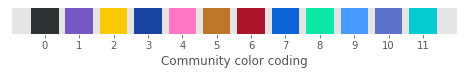

In [21]:
plt.figure(figsize=(8,.5))
plt.bar(range(len(communities.keys())),1 , color = colors)
plt.xticks(range(len(communities.keys())), range(0, len(communities.keys())))
plt.yticks([])
plt.xlabel("Community color coding")
plt.show()

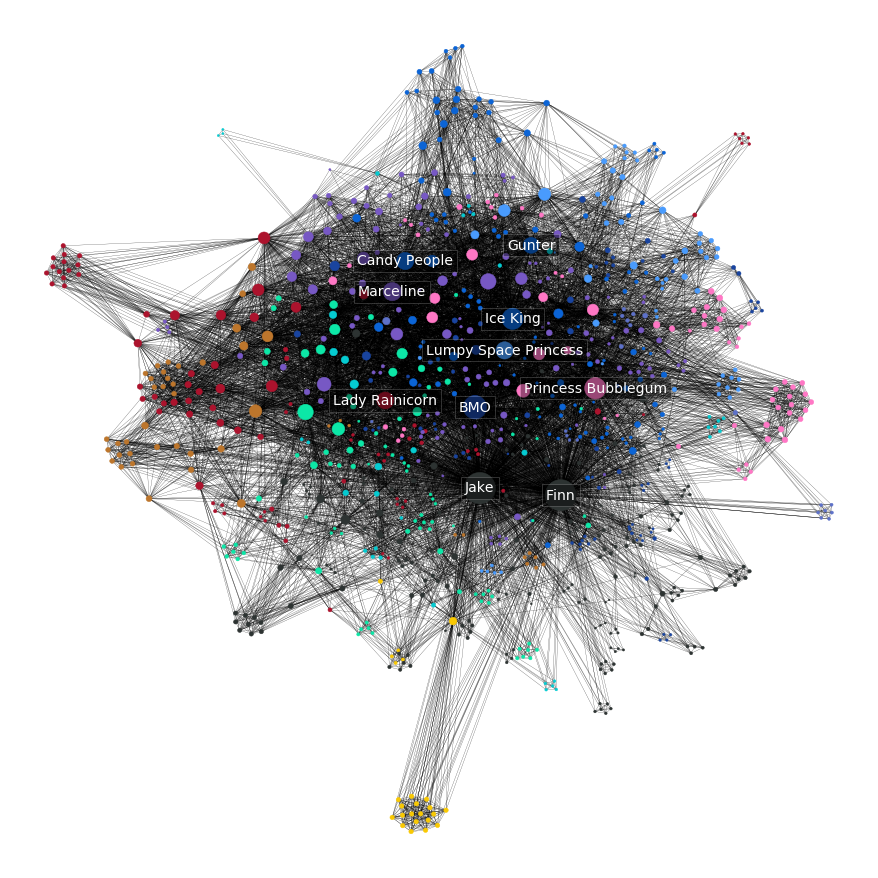

In [22]:
plt.figure(figsize=(12,12))
color_map = get_community_cmap(partition)
labels = {c:c for c in DG.nodes if c in dict(degree_all[:10]).keys()}
node_size = degree
nx.draw(G, node_size = node_size, pos = positions,
        width=.2, node_color = color_map, with_labels = False)
nx.draw_networkx_labels(DG, positions, labels, font_size = 14, font_color = 'w',
                        bbox=dict(facecolor='black', alpha=0.4) )
plt.savefig("../network_communities.png")
plt.show()

In [23]:
for i, com in enumerate(communities.values()):
    print(f"Community {i} with {len(com)} characters")

Community 0 with 187 characters
Community 1 with 130 characters
Community 2 with 24 characters
Community 3 with 80 characters
Community 4 with 69 characters
Community 5 with 46 characters
Community 6 with 88 characters
Community 7 with 121 characters
Community 8 with 91 characters
Community 9 with 58 characters
Community 10 with 21 characters
Community 11 with 38 characters


In [24]:
top_char_com = {}
for char in top_characters:
    for com in communities:
        if char in communities[com]:
            top_char_com[char] = com
pd.DataFrame(sorted(top_char_com.items(), key = lambda x: x[1]), columns = ["Character", "Community"])

,Character,Community
0,Jake,0
1,Finn,0
2,Marceline,1
3,BMO,3
4,Princess Bubblegum,4
5,Lady Rainicorn,6
6,Ice King,7
7,Candy People,7
8,Gunter,7
9,Lumpy Space Princess,9


We notice that the main characters are spread out but in a predictable manner. Ice King and his penguin Gunter are in the same community, Finn, Jake and often BMO (changes from time to time) are in the same community and so on. 

There is one particular group of characters with something very specific in commom however. A fact about Adventure Time is that there is an abundance of princesses ruling over their respective kingdoms.

In [34]:
princesses = [p for p in G.nodes if 'princess' in p.lower() and '/' not in p]
print(f"{len(princesses)} princesses")

36 princesses


In [26]:
def modularity_from_nodes(G, nodes):
    subgraph = G.subgraph(nodes)
    partition = community.best_partition(subgraph)
    modularity = community.modularity(partition, subgraph)

    communities = {}
    for p, c in partition.items():
        communities[c] = communities.get(c, [])
        communities[c].append(p)
        
    return modularity, communities

In [27]:
princess_modularity, princess_partition = modularity_from_nodes(G, princesses)
print(f"Princess modularity {princess_modularity}")

Princess modularity 0.21477822876424277


This indicates that a community of princesses are present in the network since the modularity is above 0.

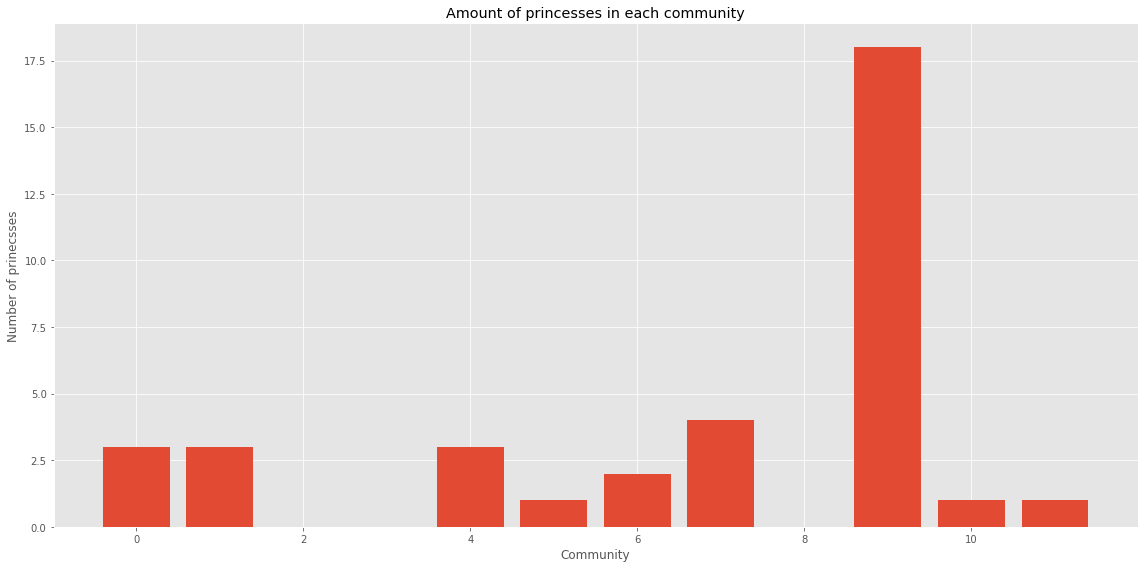

In [28]:
princess_com = {}
for char in princesses:
    for com in communities:
        if char in communities[com]:
            princess_com[char] = com

princess_dist = []
for com in communities:
    princess_dist.append(list(princess_com.values()).count(com))
plt.figure(figsize=fig_size)
plt.bar(list(communities.keys()), princess_dist)
plt.xlabel("Community")
plt.ylabel("Number of prinecsses")
plt.title("Amount of princesses in each community")
plt.tight_layout()
plt.savefig("../princess_community.png")
plt.show()

And it indeed seems as though the princesses are chunked into the same community.

# Discussion
* **What went well**
    
    We were able to get meaningful information about our initial hypothesis from the data we gathered. 


* **What is still missing? What could be improved? Why?**
    
    The community detection part could have been more elaborate. Due no predefined communities our only course of action was to look at the communities thoroughly and make up some sort of association. 
    

# References
[1] http://networksciencebook.com/